# Bring Your Own R Algorithm - Adapted
_**Create a Docker container for training R algorithms and hosting R models**_

---
## Background

R is a popular open source statistical programming language, with a lengthy history in Data Science and Machine Learning.  The breadth of algorithms available as an R package is impressive, which fuels a growing community of users.  The R kernel can be installed into Amazon SageMaker Notebooks, and Docker containers which use R can be used to take advantage of Amazon SageMaker's flexible training and hosting functionality.  This notebook illustrates a simple use case for creating an R container and then using it to train and host a model.  In order to take advantage of boto, we'll use Python within the notebook, but this could be done 100% in R by invoking command line arguments.

---
## Preparation

_This notebook was created and tested on an ml.m4.xlarge notebook instance._

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).

In [206]:
from datetime import datetime
print(str(datetime.now()))

bucket = 'rodzanto20181011'
prefix = 'sagemaker/AR-r-byo'
 
# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

2018-10-17 10:24:13.964750


Now we'll import the libraries we'll need for the remainder of the notebook.

In [207]:
print(str(datetime.now()))

import time
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

2018-10-17 10:24:14.028538


### Permissions

Running this notebook requires permissions in addition to the normal `SageMakerFullAccess` permissions. This is because we'll be creating a new repository in Amazon ECR. The easiest way to add these permissions is simply to add the managed policy `AmazonEC2ContainerRegistryFullAccess` to the role that you used to start your notebook instance. There's no need to restart your notebook instance when you do this, the new permissions will be available immediately.

---
## Code

For this example, we'll need 3 supporting code files.

### Fit

`mars.R` creates functions to fit and serve our model.  The algorithm we've chosen to use is [Multivariate Adaptive Regression Splines](https://en.wikipedia.org/wiki/Multivariate_adaptive_regression_splines).  This is a suitable example as it's a unique and powerful algorithm, but isn't as broadly used as Amazon SageMaker algorithms, and it isn't available in Python's scikit-learn library.  R's repository of packages is filled with algorithms that share these same criteria.

### Note for this adjusted version we have added the "penalty" parameter to the mars.R model, for making sure it properly takes this parameter into account!!!
---

### Serve
`plumber.R` uses the [plumber](https://www.rplumber.io/) package to create a lightweight HTTP server for processing requests in hosting.  Note the specific syntax, and see the plumber help docs for additional detail on more specialized use cases.

### Publish
Now, to publish this container to ECR, we'll run the comands below.

This command will take several minutes to run the first time.

In [208]:
%%sh

# The name of our algorithm
algorithm_name=rmars

#set -e # stop if anything fails

account=$(aws sts get-caller-identity --query Account --output text)

# Get the region defined in the current configuration (default to us-west-2 if none defined)
region=$(aws configure get region)
region=${region:-us-west-2}

fullname="${account}.dkr.ecr.${region}.amazonaws.com/${algorithm_name}:latest"

# If the repository doesn't exist in ECR, create it.

aws ecr describe-repositories --repository-names "${algorithm_name}" > /dev/null 2>&1

if [ $? -ne 0 ]
then
    aws ecr create-repository --repository-name "${algorithm_name}" > /dev/null
fi

# Get the login command from ECR and execute it directly
$(aws ecr get-login --region ${region} --no-include-email)

# Build the docker image locally with the image name and then push it to ECR
# with the full name.
docker build  -t ${algorithm_name} .
docker tag ${algorithm_name} ${fullname}

docker push ${fullname}

Login Succeeded

Step 1/7 : FROM ubuntu:16.04
 ---> b9e15a5d1e1a
Step 2/7 : MAINTAINER Amazon SageMaker Examples <amazon-sagemaker-examples@amazon.com>
 ---> Using cache
 ---> 77028ecccc19
Step 3/7 : RUN apt-get -y update && apt-get install -y --no-install-recommends     wget     r-base     r-base-dev     ca-certificates
 ---> Using cache
 ---> 264b0f2c69ad
Step 4/7 : RUN R -e "install.packages(c('mda', 'plumber'), repos='https://cloud.r-project.org')"
 ---> Using cache
 ---> e1ae9c86a960
Step 5/7 : COPY mars.R /opt/ml/mars.R
 ---> f87af01ea372
Step 6/7 : COPY plumber.R /opt/ml/plumber.R
 ---> cfbd94077c88
Step 7/7 : ENTRYPOINT ["/usr/bin/Rscript", "/opt/ml/mars.R", "--no-save"]
 ---> Running in 6d3adf1e5119
Removing intermediate container 6d3adf1e5119
 ---> 888979a83fe7
Successfully built 888979a83fe7
Successfully tagged rmars:latest
The push refers to repository [889960878219.dkr.ecr.us-east-1.amazonaws.com/rmars]
b5f1a85bd662: Preparing
75c810a6d5d8: Preparing
1cf72ebc96a5: Preparin

WARNING! Using --password via the CLI is insecure. Use --password-stdin.


---
## Data
For this illustrative example, we'll simply use some performance data from a telco example.
This is an extremely simplified version of a real dataset, extracted from a use case for predicting CPU Usage %.
Then let's copy the data to S3.

In [209]:
print(str(datetime.now()))

train_file = 'cpu.csv'
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', train_file)).upload_file(train_file)

2018-10-17 10:24:18.235387


_Note: Although we could, we'll avoid doing any preliminary transformations on the data, instead choosing to do those transformations inside the container.  This is not typically the best practice for model efficiency, but provides some benefits in terms of flexibility._

---
## Train

Now, let's setup the information needed to train a Multivariate Adaptive Regression Splines (MARS) model on the data.  In this case, we'll predict `cpu`.

First, we'll get our region and account information so that we can point to the ECR container we just created.

In [210]:
print(str(datetime.now()))

region = boto3.Session().region_name
account = boto3.client('sts').get_caller_identity().get('Account')

2018-10-17 10:24:18.363863



- Specify the role to use
- Give the training job a name
- Point the algorithm to the container we created
- Specify training instance resources (in this case our algorithm is only single-threaded so stick to 1 instance)
- Point to the S3 location of our input data and the `train` channel expected by our algorithm
- Point to the S3 location for output
- Provide hyperparamters (keeping it simple)
- Maximum run time

In [211]:
print(str(datetime.now()))

r_job = 'AR-r-byo-' + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

print("Training job", r_job)

r_training_params = {
    "RoleArn": role,
    "TrainingJobName": r_job,
    "AlgorithmSpecification": {
        "TrainingImage": '{}.dkr.ecr.{}.amazonaws.com/rmars:latest'.format(account, region),
        "TrainingInputMode": "File"
    },
    "ResourceConfig": {
        "InstanceCount": 1,
        "InstanceType": "ml.m4.xlarge",
        "VolumeSizeInGB": 10
    },
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": "s3://{}/{}/train".format(bucket, prefix),
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "CompressionType": "None",
            "RecordWrapperType": "None"
        }
    ],
    "OutputDataConfig": {
        "S3OutputPath": "s3://{}/{}/output".format(bucket, prefix)
    },
    "HyperParameters": {
        "target": "cpu",
        "degree": "3",
        "prune": "FALSE",
        "thresh": "0.003178108140324401"
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 60 * 60
    }
}

2018-10-17 10:24:18.415469
Training job AR-r-byo-2018-10-17-10-24-18


Now let's kick off our training job on Amazon SageMaker Training, using the parameters we just created.  Because training is managed (AWS takes care of spinning up and spinning down the hardware), we don't have to wait for our job to finish to continue, but for this case, let's setup a waiter so we can monitor the status of our training.

In [212]:
%%time

sm = boto3.client('sagemaker')
sm.create_training_job(**r_training_params)

status = sm.describe_training_job(TrainingJobName=r_job)['TrainingJobStatus']
print(status)
sm.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=r_job)
status = sm.describe_training_job(TrainingJobName=r_job)['TrainingJobStatus']
print("Training job ended with status: " + status)
if status == 'Failed':
    message = sm.describe_training_job(TrainingJobName=r_job)['FailureReason']
    print('Training failed with the following error: {}'.format(message))
    raise Exception('Training job failed')

InProgress
Training job ended with status: Completed
CPU times: user 64 ms, sys: 8 ms, total: 72 ms
Wall time: 4min


---
## Host

Hosting the model we just trained takes three steps in Amazon SageMaker.  First, we define the model we want to host, pointing the service to the model artifact our training job just wrote to S3.

In [213]:
print(str(datetime.now()))

r_hosting_container = {
    'Image': '{}.dkr.ecr.{}.amazonaws.com/rmars:latest'.format(account, region),
    'ModelDataUrl': sm.describe_training_job(TrainingJobName=r_job)['ModelArtifacts']['S3ModelArtifacts']
}

create_model_response = sm.create_model(
    ModelName=r_job,
    ExecutionRoleArn=role,
    PrimaryContainer=r_hosting_container)

print(create_model_response['ModelArn'])

2018-10-17 10:28:19.018045
arn:aws:sagemaker:us-east-1:889960878219:model/ar-r-byo-2018-10-17-10-24-18


Next, let's create an endpoing configuration, passing in the model we just registered.  In this case, we'll only use a few c4.xlarges.

In [214]:
print(str(datetime.now()))

r_endpoint_config = 'AR-r-byo-config-' + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
print(r_endpoint_config)
create_endpoint_config_response = sm.create_endpoint_config(
    EndpointConfigName=r_endpoint_config,
    ProductionVariants=[{
        'InstanceType': 'ml.m4.xlarge',
        'InitialInstanceCount': 1,
        'ModelName': r_job,
        'VariantName': 'AllTraffic'}])

print("Endpoint Config Arn: " + create_endpoint_config_response['EndpointConfigArn'])

2018-10-17 10:28:19.307646
AR-r-byo-config-2018-10-17-10-28-19
Endpoint Config Arn: arn:aws:sagemaker:us-east-1:889960878219:endpoint-config/ar-r-byo-config-2018-10-17-10-28-19


Finally, we'll create the endpoints using our endpoint configuration from the last step.

In [215]:
%%time

r_endpoint = 'AR-r-endpoint-' + time.strftime("%Y%m%d%H%M", time.gmtime())
print(r_endpoint)
create_endpoint_response = sm.create_endpoint(
    EndpointName=r_endpoint,
    EndpointConfigName=r_endpoint_config)
print(create_endpoint_response['EndpointArn'])

resp = sm.describe_endpoint(EndpointName=r_endpoint)
status = resp['EndpointStatus']
print("Status: " + status)

try:
    sm.get_waiter('endpoint_in_service').wait(EndpointName=r_endpoint)
finally:
    resp = sm.describe_endpoint(EndpointName=r_endpoint)
    status = resp['EndpointStatus']
    print("Arn: " + resp['EndpointArn'])
    print("Status: " + status)

    if status != 'InService':
        raise Exception('Endpoint creation did not succeed')

AR-r-endpoint-201810171028
arn:aws:sagemaker:us-east-1:889960878219:endpoint/ar-r-endpoint-201810171028
Status: Creating
Arn: arn:aws:sagemaker:us-east-1:889960878219:endpoint/ar-r-endpoint-201810171028
Status: InService
CPU times: user 152 ms, sys: 0 ns, total: 152 ms
Wall time: 5min 31s


---
## Predict
To confirm our endpoints are working properly, let's try to invoke the endpoint.

_Note: The payload we're passing in the request is a CSV string with a header record, followed by multiple new lines.  It also contains text columns, which the serving code converts to the set of indicator variables needed for our model predictions.  Again, this is not a best practice for highly optimized code, however, it showcases the flexibility of bringing your own algorithm._

In [216]:
print(str(datetime.now()))

cpu = pd.read_csv('cpu.csv')

runtime = boto3.Session().client('runtime.sagemaker')

payload = cpu.drop(['cpu'], axis=1).to_csv(index=False)
response = runtime.invoke_endpoint(EndpointName=r_endpoint,
                                   ContentType='text/csv',
                                   Body=payload)

print(payload)

result = json.loads(response['Body'].read().decode())

original = cpu['cpu'].values
predicted = np.fromstring(result[0], sep=',')
diference = ((original - predicted)/original)*100

print("Original     Predicted     Dif%")
print(re.sub(r' *\n *', '\n', np.array_str(np.c_[original, predicted, diference]).replace('[', '').replace(']', '').strip()))

#payload

2018-10-17 10:33:50.891487
subs,trans,mem
9552,1923,8.0
9680,1961,7.0
9731,1979,7.0
11666,2030,8.0
14675,2112,7.0
15265,2192,6.0
15484,2235,7.0
15723,2351,6.0
16501,2411,6.0
16890,2475,8.0
17203,2524,8.0
17707,2674,8.0
18108,2833,7.0
18266,2863,8.0
19308,2839,10.0
18224,2898,9.0
18997,3123,8.0
19505,3195,6.0
19800,3239,7.0
19546,3129,8.0
19117,3100,7.0
18774,3008,9.0
17813,2983,10.0
17304,3069,8.0
16756,3151,9.0
16749,3127,9.0
16925,3179,9.0
17231,3207,8.0

Original     Predicted     Dif%
5.5         5.96244854 -8.40815525
5.95        5.95459926 -0.07729855
6.63        6.09850844  8.01646394
7.56        7.47609815  1.10981279
8.72        8.82188035 -1.1683526
9.37        9.27449048  1.01931183
9.92        9.97263916 -0.5306367
10.17       10.54841426 -3.72088751
11.08       11.24910326 -1.52620273
12.5        12.47435794  0.2051365
13.75       12.92941562  5.96788637
13.66       13.87457292 -1.570812
13.85       13.91427586 -0.46408565
14.15       14.27316036 -0.87039122
14.89       14

We can see the result is a CSV of predictions for our target variable.  Let's compare them to the actuals to see how 
our model did.

2018-10-17 10:33:51.180743


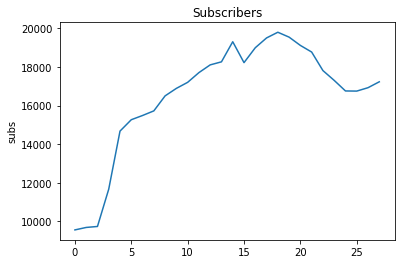

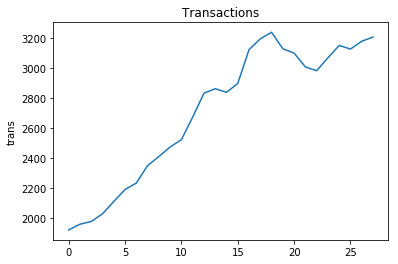

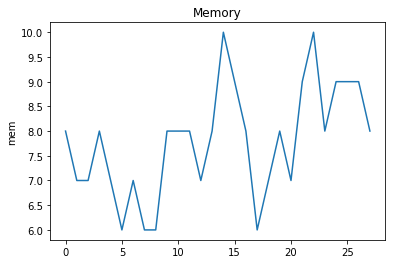

In [217]:
print(str(datetime.now()))

plt.figure(4)
plt.plot(cpu['subs'].values, label='Subscribers')
plt.ylabel('subs')
plt.title('Subscribers')
plt.figure(5)
plt.plot(cpu['trans'].values, label='Transactions')
plt.ylabel('trans')
plt.title('Transactions')
plt.figure(6)
plt.plot(cpu['mem'].values, label='Memory')
plt.ylabel('mem')
plt.title('Memory')

plt.show()


2018-10-19 07:45:21.796983


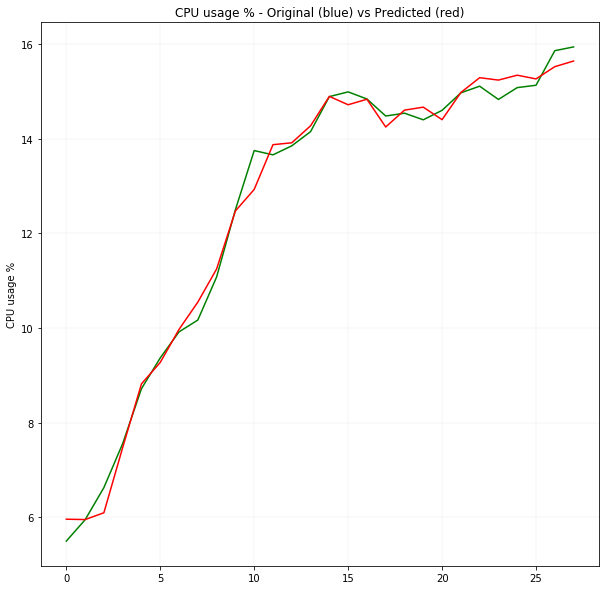

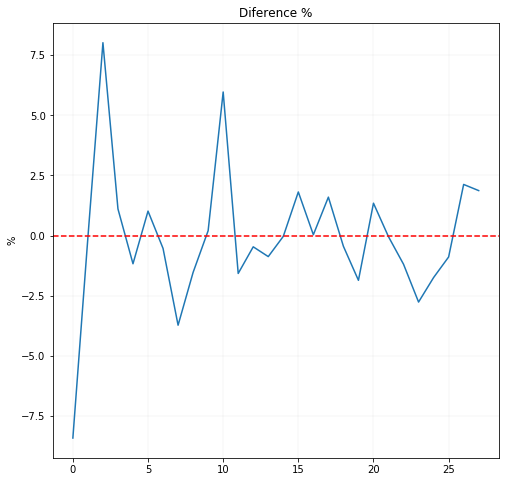

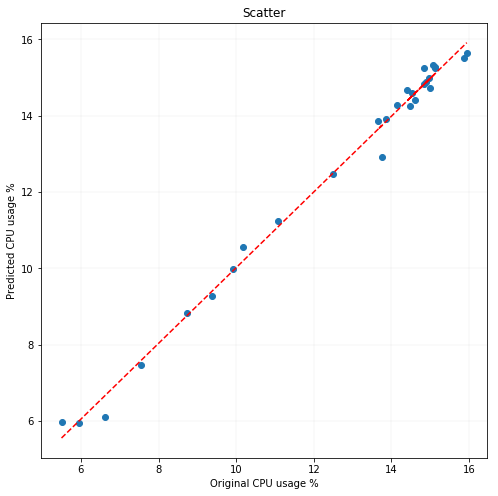

y=0.992384x+(0.095868)


In [232]:
print(str(datetime.now()))

plt.figure(0,figsize=(10,10))
plt.figure(0)
plt.plot(original, label='original', color='g')
plt.ylabel('CPU usage %')
#axes = plt.figure(0).gca()
#axes.set_ylim([4,16])
plt.plot(predicted, label='predicted', color='r')
plt.grid(color='grey', linestyle='-', linewidth=0.1, alpha=0.7)
plt.title('CPU usage % - Original (blue) vs Predicted (red)')

plt.figure(1,figsize=(8,8))
plt.figure(1)
plt.plot(diference, label='diference %')
plt.ylabel('%')
plt.axhline(y=0, color='r', linestyle='--')
plt.grid(color='grey', linestyle='-', linewidth=0.1, alpha=0.7)
plt.title('Diference %')

plt.figure(2,figsize=(8,8))
plt.figure(2)
plt.scatter(original, predicted, label='scatter')
plt.xlabel('Original CPU usage %')
plt.ylabel('Predicted CPU usage %')
plt.title('Scatter')
z = np.polyfit(original, predicted, 1)
p = np.poly1d(z)
plt.plot(original,p(original),"r--")
plt.grid(color='grey', linestyle='-', linewidth=0.1, alpha=0.7)

plt.show()

print ("y=%.6fx+(%.6f)"%(z[0],z[1]))

---
## Extensions

This notebook showcases a straightforward example to train and host an R algorithm in Amazon SageMaker.  As mentioned previously, this notebook could also be written in R.  We could even train the algorithm entirely within a notebook and then simply use the serving portion of the container to host our model.

Other extensions could include setting up the R algorithm to train in parallel.  Although R is not the easiest language to build distributed applications on top of, this is possible.  In addition, running multiple versions of training simultaneously would allow for parallelized grid (or random) search for optimal hyperparamter settings.  This would more fully realize the benefits of managed training.

### (Optional) Clean-up

If you're ready to be done with this notebook, please run the cell below.  This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [205]:
#print(str(datetime.now()))

#sm.delete_endpoint(EndpointName=r_endpoint)

2018-10-17 10:23:50.460666


{'ResponseMetadata': {'RequestId': 'de53fa78-80e0-4b6a-aa9b-7d01b3746d7b',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'de53fa78-80e0-4b6a-aa9b-7d01b3746d7b',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Wed, 17 Oct 2018 10:23:50 GMT'},
  'RetryAttempts': 0}}